In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import torch
import os
import yaml
import cv2

from IPython.display import Image, clear_output  # to display images

In [4]:
project_dir = os.path.dirname(os.getcwd())
yolo_location = os.path.join(project_dir, 'yolov5')
dataset_location = os.path.join(project_dir, 'data', 'ocr_evaluation')
weights_location = os.path.join(project_dir, 'model_weights')

output_location = dataset_location
output_name = 'detection_results'

In [5]:
%cd {yolo_location}
!python detect.py --weights {weights_location}/best.pt --img 416 --conf 0.4 --source {dataset_location} --save-txt --save-conf --project {output_location} --name {output_name}


/home/roma/5sem/Real-time_Number_Plate_Recognition/yolov5


/home/roma/5sem/Real-time_Number_Plate_Recognition/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


detect: weights=['/home/roma/5sem/Real-time_Number_Plate_Recognition/model_weights/best.pt'], source=/home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation, name=detection_results, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2024-10-21 Python-3.12.7 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5834MiB)

Fusing layers... 
YOLOv5s_custom summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/395 /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/00000.jpg: 320x416 1 License_Plate, 36.5ms


In [7]:
# input_dir = './runs/detect/exp'  # Adjust based on where YOLOv5 saves outputs
input_img_dir = dataset_location
input_txt_dir = f"{dataset_location}/detection_results/labels"
output_dir = f'{dataset_location}/cropped_plates'
os.makedirs(output_dir, exist_ok=True)

for img_file in os.listdir(input_img_dir):
    if img_file.endswith('jpg'):
        img_path = os.path.join(input_img_dir, img_file)
        img = cv2.imread(img_path)
        img_height, img_width = img.shape[:2]

        txt_path = os.path.join(input_txt_dir, img_file[:-3]+'txt')
        try:
            with open(txt_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, width, height, conf = map(float, line.split())
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height

                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)
                    cropped_plate = img[y1:y2, x1:x2]

                    plate_save_path = os.path.join(output_dir, f'plate_{img_file}')
                    cv2.imwrite(plate_save_path, cropped_plate)
                    break
        except FileNotFoundError:
            print(f"File not found: {txt_path}")

File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/detection_results/labels/00591.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/detection_results/labels/01026.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/detection_results/labels/01803.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/detection_results/labels/01003.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/detection_results/labels/00440.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/detection_results/labels/01595.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/detection_results/labels/00573.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/detection_results/labels/00741.txt
File not found: /home/ro

In [8]:
import easyocr
import os
import cv2
import matplotlib.pyplot as plt

reader = easyocr.Reader(['en'])

In [9]:
source_dataset_location = dataset_location
cropped_dataset_location = output_dir
results_dir = f"{dataset_location}/output_results"
scale_dataset_location = f"{dataset_location}/scaled_plates"
cropped_dataset_location

'/home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/cropped_plates'

In [10]:
os.makedirs(results_dir, exist_ok=True)
os.makedirs(scale_dataset_location, exist_ok=True)

for img_file in os.listdir(cropped_dataset_location):
    if img_file.endswith('jpg'):
        img_path = os.path.join(cropped_dataset_location, img_file)

        img = cv2.imread(img_path)

        scale_factor = 2
        img = cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor)
        img = cv2.GaussianBlur(img,(5,5),0)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        output_path = os.path.join(scale_dataset_location, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        result = reader.readtext(output_path)
    
        output_txt_path = os.path.join(results_dir, img_file[:-3]+'txt')
        with open(output_txt_path, 'w') as f:
            for (bbox, text, prob) in result:
                f.write(f'Text: {text}, Probability: {prob}\n')


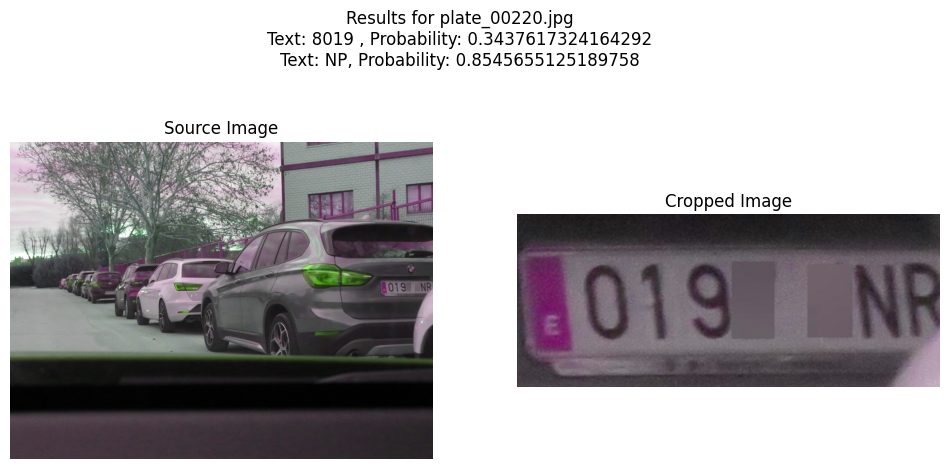

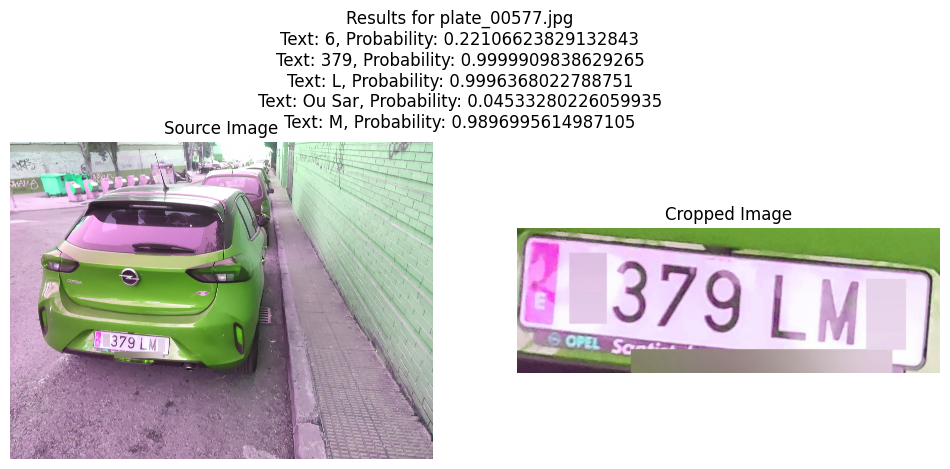

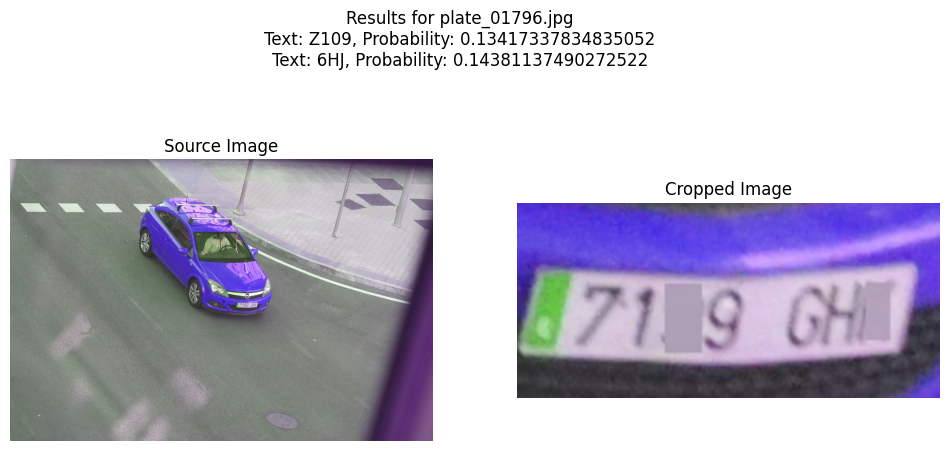

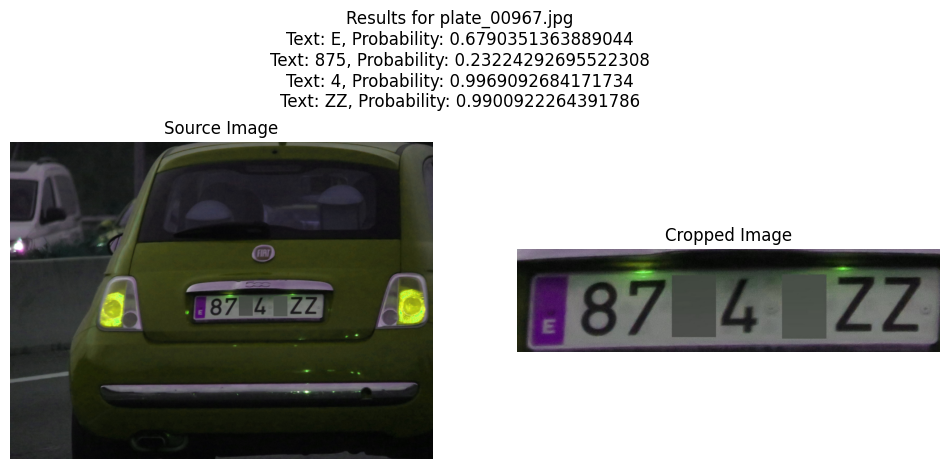

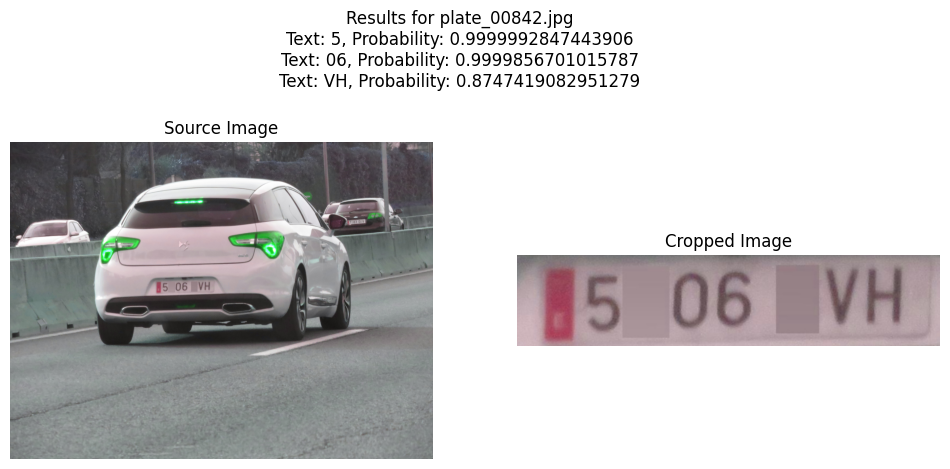

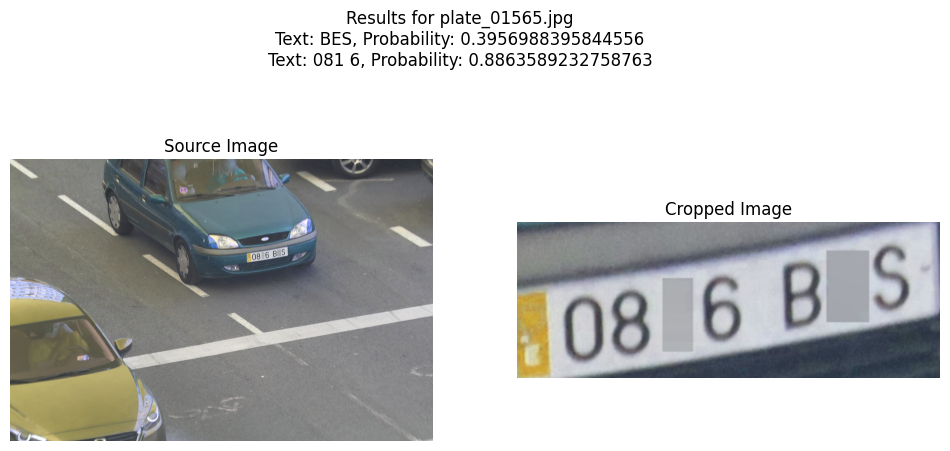

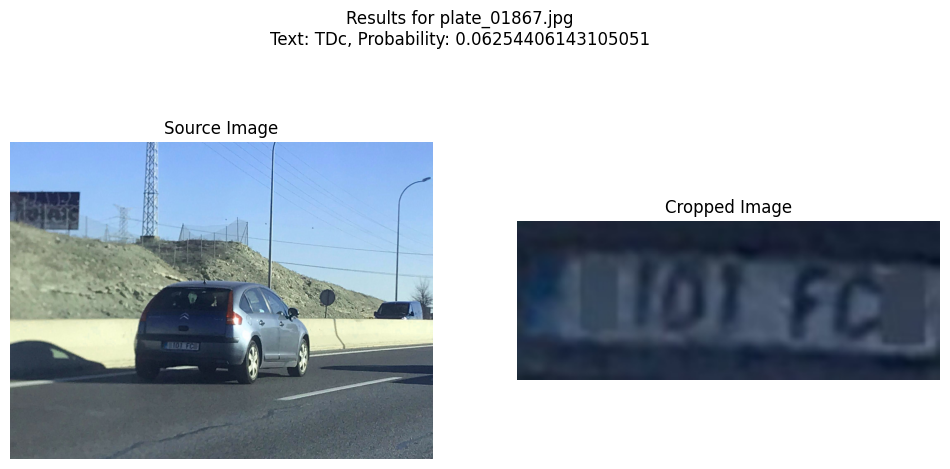

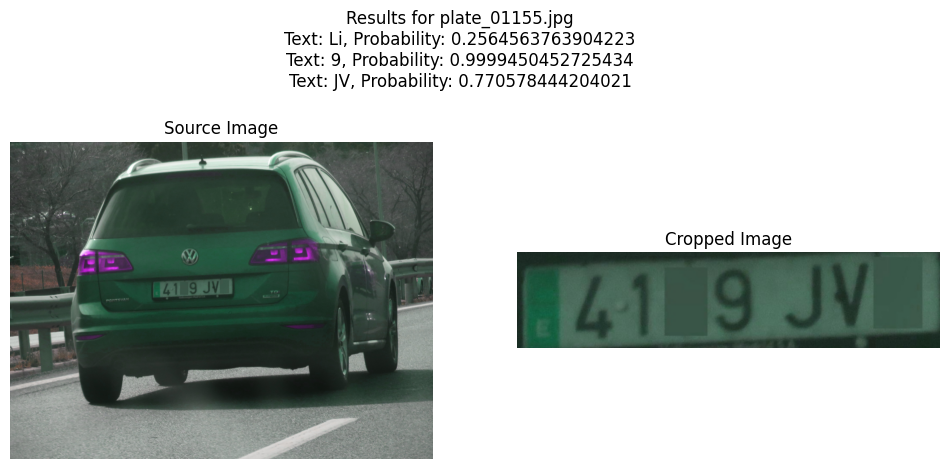

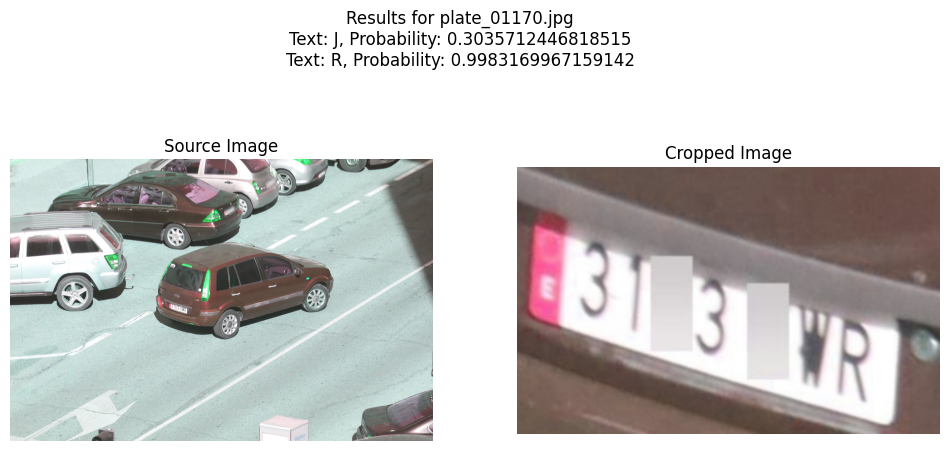

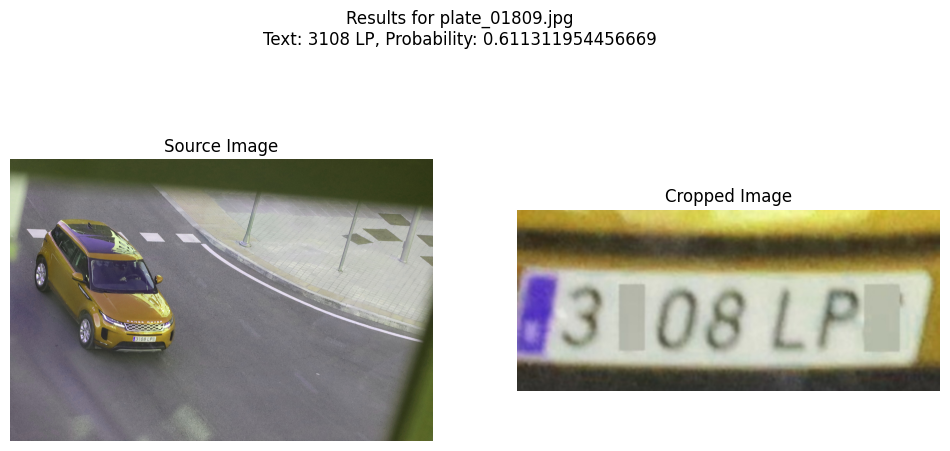

In [11]:
first_dataset = source_dataset_location
second_dataset = scale_dataset_location

for img_file in os.listdir(second_dataset)[:10]:
    if img_file.endswith('jpg'):
        cropped_img_path = os.path.join(second_dataset, img_file)
        source_img_path = os.path.join(first_dataset, img_file[6:])
        results_path = os.path.join(results_dir, img_file[:-3]+'txt')

        cropped_img = cv2.imread(cropped_img_path)
        source_img = cv2.imread(source_img_path)
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        source_img_rgb = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
        
        with open(results_path, 'r') as f:
            results = f.read()
        
        # Plot images and results
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(source_img_rgb)
        axes[0].set_title('Source Image')
        axes[0].axis('off')
        
        axes[1].imshow(cropped_img_rgb)
        axes[1].set_title('Cropped Image')
        axes[1].axis('off')
        
        plt.suptitle(f'Results for {img_file}\n{results}', fontsize=12)
        plt.show()